# Step 1: Step 1: Import Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Step 2: Load and Explore the Data

In [29]:
# Load dataset
df = pd.read_csv("customer_segmentation_data.csv")  # replace with actual file name
print(df.head())



   customer_id  age  gender  annual_income  spending_score  years_as_customer  \
0            1   33  Female        76668.0            78.8                2.4   
1            2   22  Female        58480.0            48.4                1.9   
2            3   20    Male        60546.0            68.5                1.4   
3            4   31    Male        37600.0            73.8                0.9   
4            5   39    Male        38380.0            27.3                0.7   

   purchases_per_year  avg_order_value preferred_channel   region  
0                  18              NaN            Online  Central  
1                  18           126.72            Online  Central  
2                  12           152.93            Online    South  
3                  12            85.39            Online     West  
4                  11            27.12              Both    South  


In [30]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         8000 non-null   int64  
 1   age                 8000 non-null   int64  
 2   gender              8000 non-null   object 
 3   annual_income       7920 non-null   float64
 4   spending_score      8000 non-null   float64
 5   years_as_customer   7920 non-null   float64
 6   purchases_per_year  8000 non-null   int64  
 7   avg_order_value     7920 non-null   float64
 8   preferred_channel   8000 non-null   object 
 9   region              8000 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 625.1+ KB
None


In [31]:
print(df.describe())

       customer_id          age  annual_income  spending_score  \
count   8000.00000  8000.000000    7920.000000     8000.000000   
mean    4000.50000    41.239000   51830.935859       52.988138   
std     2309.54541    14.863504   19870.546069       22.080658   
min        1.00000    18.000000   20000.000000        1.000000   
25%     2000.75000    29.000000   37147.750000       34.700000   
50%     4000.50000    39.000000   48219.000000       52.000000   
75%     6000.25000    53.000000   62180.750000       70.100000   
max     8000.00000    80.000000  132897.000000      100.000000   

       years_as_customer  purchases_per_year  avg_order_value  
count        7920.000000         8000.000000      7920.000000  
mean            3.930177           15.474375        84.943758  
std             2.976288            7.519602        50.545214  
min             0.100000            1.000000        10.000000  
25%             1.700000           10.000000        49.480000  
50%             3.100

In [32]:


# Basic statistics
print(df.describe())

       customer_id          age  annual_income  spending_score  \
count   8000.00000  8000.000000    7920.000000     8000.000000   
mean    4000.50000    41.239000   51830.935859       52.988138   
std     2309.54541    14.863504   19870.546069       22.080658   
min        1.00000    18.000000   20000.000000        1.000000   
25%     2000.75000    29.000000   37147.750000       34.700000   
50%     4000.50000    39.000000   48219.000000       52.000000   
75%     6000.25000    53.000000   62180.750000       70.100000   
max     8000.00000    80.000000  132897.000000      100.000000   

       years_as_customer  purchases_per_year  avg_order_value  
count        7920.000000         8000.000000      7920.000000  
mean            3.930177           15.474375        84.943758  
std             2.976288            7.519602        50.545214  
min             0.100000            1.000000        10.000000  
25%             1.700000           10.000000        49.480000  
50%             3.100

# Step 3: Data Preprocessing

In [35]:
# Check for missing values
print(df.isnull().sum())

customer_id           0
age                   0
gender                0
annual_income         0
spending_score        0
years_as_customer     0
purchases_per_year    0
avg_order_value       0
preferred_channel     0
region                0
dtype: int64


In [36]:
# Drop rows with any NaN values
df_cleaned = df.dropna()

# For numerical columns: fill with column mean
df.fillna(df.mean(numeric_only=True), inplace=True)

# For categorical columns: fill with mode
for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_20516\3357583897.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [22]:
# Encode categorical variables
label_cols = ['preferred_channel', 'gender', 'region']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [23]:
# Optional: remove 'Customer ID' as it's not useful for clustering
df.drop('customer_id', axis=1, inplace=True)

In [24]:
# Normalize numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

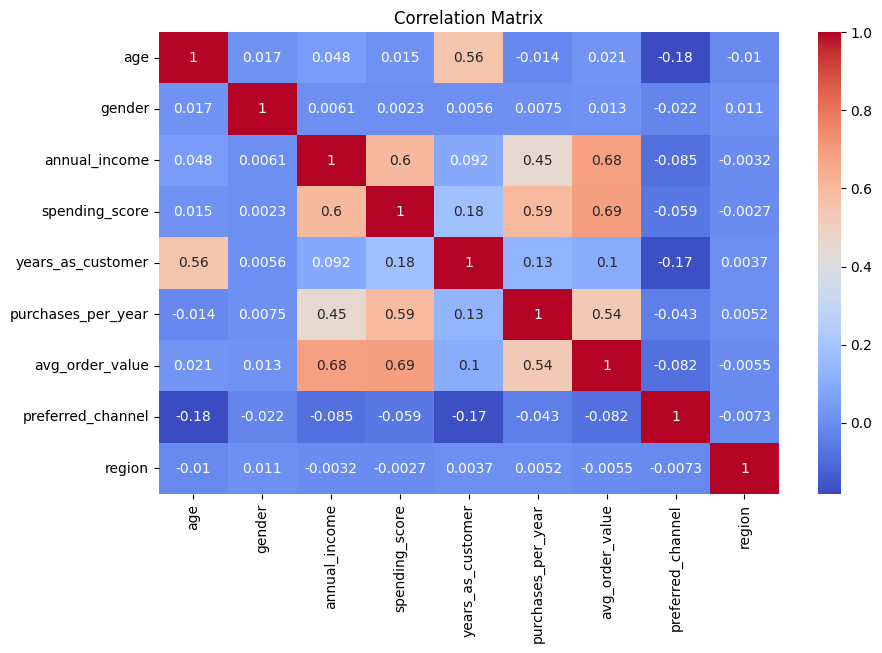

In [25]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#  Step 4: Determine Optimal Clusters (Elbow & Silhouette)

In [27]:
# Elbow Method
wcss = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, preds)
    print(f"Silhouette Score for {k} clusters: {score:.4f}")

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Silhouette Score:

In [ ]:
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    print(f"Silhouette Score for {i} clusters: {score:.3f}")


# Step 5: Apply K-Means Clustering (Assume Optimal K = 4)

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_df)


# Step 6: Analyze Cluster Characteristics

In [ ]:
# Cluster size
print(df['Cluster'].value_counts())

# Mean values per cluster
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='annual_income', y='spending_score', hue='Cluster', palette='Set2')
plt.title("Customer Clusters")
plt.show()
